# Prepare Before Training
- Import require module
- Import data
- Prepare data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional
import pandas as pd

# imprort data from data.csv as numpy array
data = pd.read_csv('data.csv')      # read data from csv file
data = data.to_numpy()              # convert data to numpy array

# shuffle the data
shuffle_idx = np.random.permutation(data.shape[0])
data = data[shuffle_idx]

# split data into x_data and y_data
x_data = data[:, 0:2]              # get x_train from data
y_data = data[:, 2:3]              # get y_train from data

# split data into train and test(80% train, 20% test)
num_points = x_data.shape[0]
num_train = int(num_points*0.8)
num_test = num_points - num_train

# split data into train and test
x_train = x_data[:num_train]
y_train = y_data[:num_train]

x_test = x_data[num_train:]
y_test = y_data[num_train:]

# turn x_train and x_test into torch tensor, and 
x_train = torch.from_numpy(x_train).to(torch.float32)
x_test = torch.from_numpy(x_test).to(torch.float32)

# one-hot encoding on y_train and y_test
y_train = torch.from_numpy(y_train).to(torch.float32)
y_train = torch.nn.functional.one_hot(y_train.to(torch.int64), 3).to(torch.float32)
y_train = y_train.squeeze()

y_test = torch.from_numpy(y_test).to(torch.float32)
y_test = torch.nn.functional.one_hot(y_test.to(torch.int64), 3).to(torch.float32)
y_test = y_test.squeeze()

# print out the shape of train and test data
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# save data into csv file
np.savetxt('my_inputs.csv', x_train, delimiter=',')
np.savetxt('my_labels.csv', y_train, delimiter=',')

# save test data into csv file
np.savetxt('my_test_inputs.csv', x_test, delimiter=',')
np.savetxt('my_test_labels.csv', y_test, delimiter=',')


x_train shape: torch.Size([720, 2])
y_train shape: torch.Size([720, 3])
x_test shape: torch.Size([180, 2])
y_test shape: torch.Size([180, 3])


# Model Training 
- create the model
- Train the model
- plot Epoch and Loss

device is cuda
<bound method Module.parameters of MyModel(
  (linear_1): Linear(in_features=2, out_features=30, bias=True)
  (linear_2): Linear(in_features=30, out_features=30, bias=True)
  (linear_3): Linear(in_features=30, out_features=3, bias=True)
  (LogSoftmax): LogSoftmax(dim=0)
  (relu): ReLU()
)>


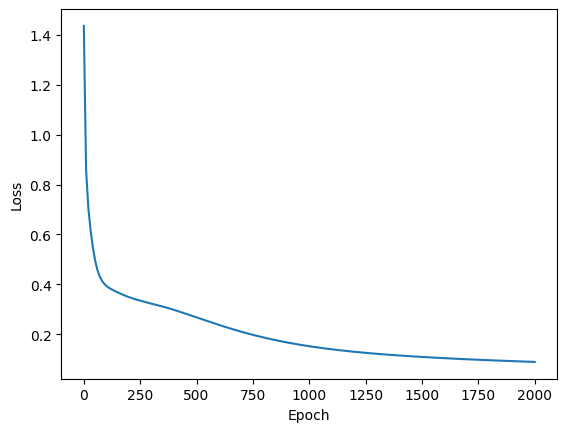

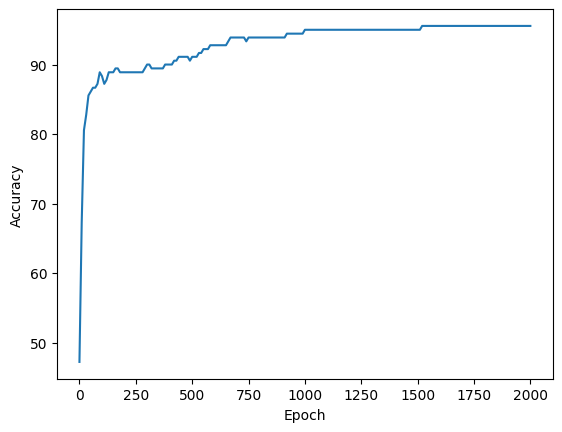

In [7]:
# create model

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"# Enable CUDA if possible
print(f"device is {device}")

class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        
        hidden1_dim = 30
        hidden2_dim = 30

        self.linear_1 = nn.Linear(input_dim, hidden1_dim)
        self.linear_2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.linear_3 = nn.Linear(hidden2_dim, output_dim)

        #self.linear_4 = nn.Linear(hidden3_dim, output_dim)
        self.LogSoftmax = nn.LogSoftmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        outputs = self.linear_1(inputs).requires_grad_() 
        outputs = self.relu(outputs).requires_grad_()

        outputs = self.linear_2(outputs).requires_grad_()
        outputs = self.relu(outputs).requires_grad_()
        
        outputs = self.linear_3(outputs).requires_grad_()
        outputs = self.LogSoftmax(outputs).requires_grad_()
        
        #outputs = self.linear_3(outputs).requires_grad_()
        #outputs = self.linear_4(outputs).requires_grad_()

        #outputs = self.relu(outputs).requires_grad_()
        #outputs = self.LogSoftmax(outputs).requires_grad_()
        return outputs
        
# Create an instance of the model and send it to target device
torch.manual_seed(37)
model = MyModel(2,3).to(device)

print(model.parameters)# Type of parameter object

# Create a loss function
criterion = nn.CrossEntropyLoss()  

# Create an optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(params=model.parameters(),lr=learning_rate)

num_epochs = 2001 # Train for longer\
softmax = nn.Softmax(dim=0)
# Put data to target device
inputs, labels = x_train.to(device), y_train.to(device)

# creat a list for store accurcy and loss
loss_list = []
accuracy_list = []

# Train the model
for epoch in range(num_epochs):
    
    predicts = model(inputs).squeeze()
    loss = criterion(predicts,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # store epoch and loss into list every 10 epoch
    if epoch % 10 == 0:
        
        # put loss into cpu
        loss = loss.cpu()
        loss = loss.item()

        # append [epoch, loss] to loss_list
        loss_list.append([epoch, loss])

        # calculate accuracy
        
        # put x_test to target device
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        # get the predict result
        predicts = model(x_test).squeeze()

        # compare the predict result with the test data
        corrects = 0
        for i in range(len(predicts)):
            if torch.argmax(predicts[i]) == torch.argmax(y_test[i]):
                corrects += 1

        accruacy = corrects/len(predicts)*100
        
        #store accuracy into accuracy_list
        accuracy_list.append([epoch, accruacy])
        

# plot loss_list
loss_list = np.array(loss_list)
plt.plot(loss_list[:,0], loss_list[:,1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot accuracy_list
accuracy_list = np.array(accuracy_list)
plt.plot(accuracy_list[:,0], accuracy_list[:,1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


# Test the model
- Use x_test and y_test(split from original data) to test the model
- Output the accruacy of the model

In [10]:
# put x_test to target device
x_test = x_test.to(device)
y_test = y_test.to(device)

# eveulate the model accurcy by using test data

# get the predict result
predicts = model(x_test).squeeze()

# calcuate the loss
loss = criterion(predicts,y_test)
print(f'loss: {loss}')

# calcuate the accuracy

# compare the predict result with the test data
corrects = 0
for i in range(len(predicts)):
    if torch.argmax(predicts[i]) == torch.argmax(y_test[i]):
        corrects += 1

accruacy = corrects/len(predicts)*100

# print out the accuracy
print(f'Accuracy: {accruacy:.2f}%')

loss: 0.11007045209407806
Accuracy: 95.56%
